# Adaptive Boost (AdaBoost) Algorithm

* $u^{(1)}$ = [$\frac{1}{N}$,$\frac{1}{N}$,$\frac{1}{N}$,......,$\frac{1}{N}$]



  for t = 1,2...,T : 
  
* obtain $g_{t}$ by A(D,$u_{t}$), where A tries to min $u_{t}$, weighted 0/1 error


* update $u_{t}$ to $u_{t+1}$ by
$$[y_{n}\neq g_{t}(x_{n})]:u^{t+1}_{n} \leftarrow u^{t}_{n}*\xi_{t} $$

$$[y_{n} = g_{t}(x_{n})]:u^{t+1}_{n} \leftarrow \frac{u^{t}_{n}}{\xi_{t}}$$

where $\xi_{t}$ = $\sqrt{\frac{1-\epsilon_{t}}{\epsilon_{t}}}$  and $$\epsilon_{t}=\frac{\Sigma^{N}_{n=1}u^{t}_{n}[y_{n}\neq g_{t}(x_{n})]}{\Sigma^{N}_{n=1}u^{t}_{n}}$$

* compute $\alpha_{t} = ln(\xi_{t})$ 

return $G(x) = sign(\Sigma^{T}_{t=1}\alpha_{t}g_{t}(x))$

Adboost的核心概念就是放大錯誤的點的權重，縮小正確的點的權重。透過AdBoost，我們只要找到T個不同的 $g_{t}$，$g_{t}$ 的表現也不用太好，其實只要稍稍比隨便亂猜好一點就可以了，然後我們將這 T 個$g_{t}$ aggregate起來，就可以得到一個表現還不錯的 G(x)。當然AdaBoost這樣操作背後的意義其實是每一輪 t 都透過 Gradient Descent往下一輪更新，而更新錯誤/正確點的權重的同時，也在確保 $g_{t+1}$ diverse from $g_{t}$，如果 $g_{t}$ 和 $g_{t+1}$ 相近的話，那兩個相近的 g 相加也只會得到另一個相近的 g'。

我們這裡使用的 A 是 decision_stump，並透過計算個輪的 $g_{t}$，得到 G(x)。

In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt

X_train = np.genfromtxt("/Users/huangyuchen/Desktop/ML_NTU/hw2_adaboost_train.dat.txt")
X_test = np.genfromtxt("/Users/huangyuchen/Desktop/ML_NTU/hw2_adaboost_test.dat.txt")

X_train.shape,X_test.shape

((100, 3), (1000, 3))

### 先偷看一下data。

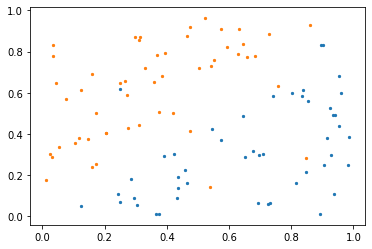

In [2]:
plt.scatter(X_train[X_train[:,-1] == 1][:, 0], X_train[X_train[:,-1] == 1][:, 1], s = 5, label='1')
plt.scatter(X_train[X_train[:,-1] ==-1][:, 0], X_train[X_train[:,-1] ==-1][:, 1], s = 5, label='-1')

###  先將獲得Theta的方程式定義出來，一樣是取單一維度上任兩點之間的中點當作Theta。

In [3]:
def obtaintheta(x):
    TrainX1 = sorted(x)
    Second1 = np.append(TrainX1[1:],(TrainX1[-1]))
    Theta = np.insert((TrainX1+Second1)/2,0,TrainX1[0]-0.1,0)
    Theta[-1] = TrainX1[-1] + 0.1
    return Theta

Theta1 = obtaintheta(X_train[:,0])
Theta2 = obtaintheta(X_train[:,1])
Theta = np.c_[Theta1,Theta2]

### 定義decision_stump function，和尋找維度與Theta與s。

下方我們用broadcast的性質一次性的計算所以Theta的值，因為要找的是$g_{t}u^{t}$的最小值因此我們把整個舉證拿去對u內積，找到最小值對應的值、s以及index。

In [4]:
def decision(X3,Theta3,Y3,U,s):
    
    ### 進行矩陣化運算，把輸入的data point擴展到和Theta3同樣多列，利用np可以broadcast的性質一次性運算。###
    X1 = np.tile(X3,(len(Theta3),1)) 
    g1 = s[0]*np.sign((X1.T - Theta3))
    g2 = s[1]*np.sign((X1.T - Theta3))
    ## 因為np.sign會把等於0的值sign成0，所以這邊手動調整一下。##
    g1[g1 == 0] = 1
    g2[g2 == 0] = 1
    result1 = (g1.T!=Y3).dot(U)
    result2 = (g2.T!=Y3).dot(U)
    min1 = min(result1)
    min2 = min(result2)
    ## 這裡先決定是 1 or -1##
    if min1 > min2:
        mino = min2
        minde = np.argmin(np.sum(result2,axis=1))
        s = s[1]
    else:
        mino = min1
        minde = np.argmin(np.sum(result1,axis=1))
        s = s[0]
        
    return mino,minde,s

接著再對兩個維度分別使用decision，找出minimum of minimum。

In [5]:
def alldata(X1,Y1,U,Theta1):
    ## 這裡決定是X的哪一個維度##
    mino1,minde1,s1 = decision(X1[:,0],Theta1[:,0],Y1,U,[1,-1])  
    mino2,minde2,s2 = decision(X1[:,1],Theta1[:,1],Y1,U,[1,-1])
    
    if mino1 > mino2:
        index = 1
        minu = mino2
        s = s2
        minde = minde2
    else:
        index = 0
        minu = mino1
        s = s1
        minde = minde1
    return minu,s,minde,index

In [6]:
def adboost(X0,Y0,Theta0):
    ## 初始U##
    E = []
    pack = []
    U1 = np.ones((len(X0),1))*(1/len(X0))
    result = np.zeros((len(X0),))
    for i in range(300):
        minu,s,minde,index = alldata(X0,Y0,U1,Theta0)
        g = s*np.sign(X0[:,index] - Theta0[:,index][minde])
        ## 這裡一樣手動修正np.sign##
        g[g==0] = 1
        ## 為了更新u，這裡要計算epsilon＃＃
        ep =(g!=Y0).dot(U1)/(np.sum(U1))
        di = np.sqrt(( 1 - ep )/ep)
        alpha = np.log(di)
        ## 為了之後要算E_out，把計算g和G的元素都先存起來。
        pack.append([alpha,s,minde,index])
        idx1 = g!= Y0
        idx2 = g == Y0
        U1[idx1] = U1[idx1]*di       
        U1[idx2] = U1[idx2]/di 
        result = result + alpha*g

        E.append(np.mean(np.sign(result)!=X_train[:,-1]))
       
    return np.mean(np.sign(result)!=Y0),E,pack

Ein, Error_in, pa= adboost(X_train[:,:-1],X_train[:,-1],Theta)

print("Ein(G) :",Ein)

Ein(G) : 0.0


### AdaBoost 預測的錯誤率的確隨著T上升而下降。

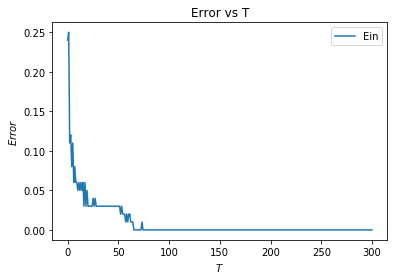

In [7]:
w_ = np.linspace(0,300,300)
fig = plt.figure()
plt.plot(w_,Error_in)

plt.title('Error vs T')
plt.ylabel("$Error$ ")
plt.xlabel("$T$")
plt.legend(['Ein'])

In [8]:
w_ = np.linspace(0,300,300)
E_out = np.zeros((1,len(X_test)))
y_test = np.reshape(X_test[:,-1],(1,-1))
Eo = []
for i in range(300):
    ## 這裡計算每一輪的 alpha(t)*g(t)，然後合成G。
    E_out += [pa[i][0]*(pa[i][1]*np.sign(X_test[:,pa[i][3]] - Theta[:,pa[i][3]][pa[i][2]]))]
    Eo.append(np.mean(np.sign(E_out)!=y_test))

print("Eout(G) :",np.mean(np.sign(E_out)!=y_test))

Eout(G) : 0.132


### E_out 預測的錯誤率也隨著T上升而下降。

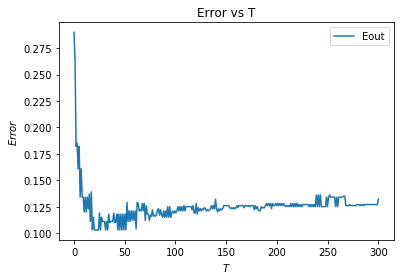

In [9]:
plt.plot(w_,Eo)
plt.title('Error vs T')
plt.ylabel("$Error$ ")
plt.xlabel("$T$")
plt.legend(['Eout'])